# Bayesian Data Analysis - Assignment 7

## 1 Linear model with drowning data

All source code for section 1 is at the end of the section. If this section is to be executed, the source code need to be ran first for the functions in the section to be referenced



**i)** Trending in the number of people drown per year. 

There is a **decreasing trend** in the number of people drown per year from 1980 to 2016. The trend can be seen in the plot below

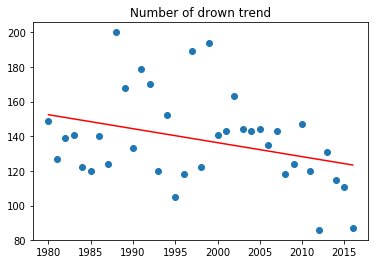

In [2]:
plot_trend()

Below is **the histogram of the slope** of the linear model

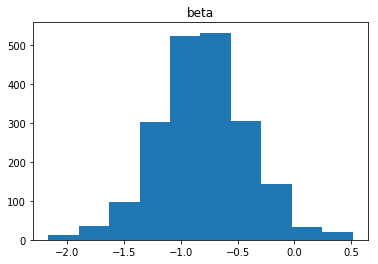

In [3]:
plot_beta_hist()

**ii)** The **histogram of the posterior predictive distribution** for number of people drown in year 2019.

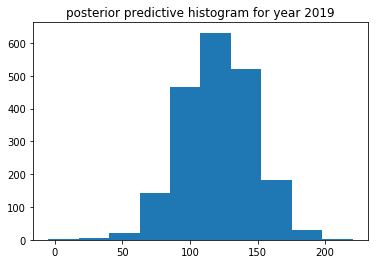

In [4]:
plot_ypred_hist()

### Addition answers
1. The fixes includes:
    * addding lower bound to sigma
    * using xpred for ypred calculation instead of mu  
2. Using Z probability table, the z value for the given confidence level is 2.58 . Then the suitable approximate numerical value for τ: **26.7**  
3. Source code to implement the prior: **see stan model (model_with_prior) belows**

In [5]:
model_with_prior="""
data {
    int<lower=0> N; // number of data points
    vector[N] x; // observation year
    vector[N] y; // observation number of drowned
    real xpred; // prediction year
    real pmubeta; // prior mean for beta
    real ptaubeta; // prior std for beta
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + beta*x;
}
model {
    beta ~ normal(pmubeta, ptaubeta);
    y ~ normal(mu, sigma);
}
generated quantities {
    real ypred;
    ypred = normal_rng(alpha + beta*xpred, sigma);
}
"""

#### Source code for part 1

In [1]:
%%capture
import pystan
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Data
raw_data = np.loadtxt('drowning.txt')
year = raw_data[:,0]
drown_count = raw_data[:,1]

# Model
stan_model="""
data {
    int<lower=0> N; // number of data points
    vector[N] x; // observation year
    vector[N] y; // observation number of drowned
    real xpred; // prediction year
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + beta*x;
}
model {
    y ~ normal(mu, sigma);
}
generated quantities {
    real ypred;
    ypred = normal_rng(alpha + beta*xpred, sigma);
}
"""

# Fit model
data = dict(N=37, x=year, y=drown_count, xpred=2019)        
sm = pystan.StanModel(model_code=stan_model)
fit = sm.sampling(data=data, iter=1000, chains=4)
samples = fit.extract(permuted=True)

# Prepare functions for report
def plot_trend():
    plt.scatter(year, drown_count)
    year_x = np.arange(1980, 2017, 1)
    beta_mean = np.mean(samples['beta'])
    alpha_mean = np.mean(samples['alpha'])
    drown_count_y = [alpha_mean + x * beta_mean for x in year_x]
    plt.plot(year_x, drown_count_y, color='r')
    plt.title('Number of drown trend')
    plt.show()


def plot_beta_hist():
    plt.hist(samples['beta'])
    plt.title('beta')
    plt.show()
    
def plot_ypred_hist():
    plt.hist(samples['ypred'])
    plt.title('posterior predictive histogram for year 2019')
    plt.show()

## 1 Hierarchical model: factory data with Stan

Some bootstraping code

In [6]:
import pystan
import numpy as np
import pickle
import matplotlib.pyplot as plt

raw_data = np.loadtxt('factory.txt')
x = np.tile(np.arange(1, 7), raw_data.shape[0])
y = raw_data.ravel()

### Separate model
The answers are  after the source code

In [7]:
%%capture
model="""
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  vector[K] mu;        // group means
  vector<lower=0>[K] sigma; // group std
}
model {
  y ~ normal(mu[x], sigma[x]);
}
generated quantities {
    real ypred_6; // predictive distribution for the 6th machine
    ypred_6 = normal_rng(mu[6], sigma[6]);
}
"""

data = dict(N=30, K=6, x=x, y=y)
sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=data, iter=1000, chains=4)
samples = fit.extract(permuted=True)

def plot_i_ii():
    plt.hist(samples['mu'][:,5])
    plt.title('Posterior distribution of 6th machine')
    plt.show()
    plt.hist(samples['ypred_6'])
    plt.title('Predictive distribution of 6th machine')
    plt.show()
    

##### Stan model inference

In [8]:
print(fit)

Inference for Stan model: anon_model_befaea1cc6bd57a6664f33c36bb75810.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     75.14    1.02  18.74  40.15  68.09   75.7  83.43 108.69    339   1.01
mu[2]    106.51    0.36   9.44  87.17 101.71 106.25 111.06 124.65    674   1.01
mu[3]      87.3     0.5  12.24  63.23  82.34  87.43  92.58 108.24    600    1.0
mu[4]     112.0    0.28   6.67 100.08 108.86  111.7 114.76 126.88    574    1.0
mu[5]     89.16    0.43  10.01  67.07   85.1  89.63  94.12 106.51    548    1.0
mu[6]     87.32    0.62  16.58  56.84  78.91  86.42  95.13 123.99    725    1.0
sigma[1]  32.22    1.44  26.54  12.36   19.2  25.55   36.2   97.7    339   1.01
sigma[2]   18.5    0.43  11.26   7.67  11.67  15.32  21.25  50.07    677    1.0
sigma[3]  21.54    0.85  18.79   8.32  12.54  16.79  24.15  62.18    487    1.0
sigma[4]  12.

##### Answers for i) and ii)

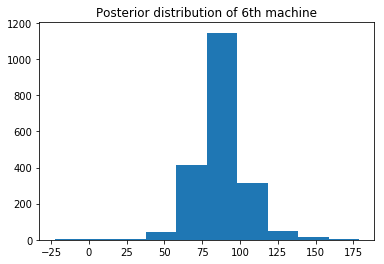

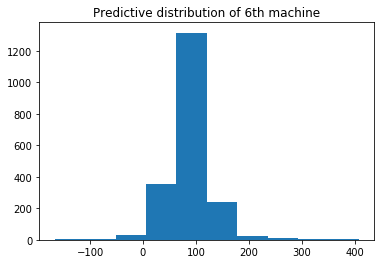

In [9]:
plot_i_ii()

##### Answer for iii)
This histogram for the 7th machine should be the same as in i) for the 6th machine because they have the same distribution for this case

### Pool model
The answers are  after the source code.
Pool model stan code is very similar to separate model. Sigma is a single value in this case

In [10]:
%%capture
model="""
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  vector[K] mu;        // group means
  real<lower=0> sigma; // common std
}
model {
  y ~ normal(mu[x], sigma);
}
generated quantities {
    real ypred_6; // predictive distribution for the 6th machine
    ypred_6 = normal_rng(mu[6], sigma);
}
"""

data = dict(N=30, K=6, x=x, y=y)
sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=data, iter=1000, chains=4)
samples = fit.extract(permuted=True)

def plot_i_ii():
    plt.hist(samples['mu'][:,5])
    plt.title('Posterior distribution of 6th machine')
    plt.show()
    plt.hist(samples['ypred_6'])
    plt.title('Predictive distribution of 6th machine')
    plt.show()
    

##### Stan model inference

In [11]:
print(fit)

Inference for Stan model: anon_model_28598bc7595af8884de7a43b9ba84b5a.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]    75.91    0.13   6.97  61.57  71.63  76.02  80.29  90.06   2829    1.0
mu[2]   106.34    0.15   6.95  92.19  101.7  106.2 110.62 120.59   2273    1.0
mu[3]     88.0    0.14   6.92  74.84  83.38  87.84   92.6 101.93   2591    1.0
mu[4]   111.78    0.12   6.71  99.04 107.09  111.8 116.43 124.73   3057    1.0
mu[5]    90.11    0.12    6.8  77.11  85.69  90.03   94.6 104.14   2997    1.0
mu[6]    86.16    0.13   6.98  72.08  81.69  86.28  90.71 100.13   2827    1.0
sigma    15.16    0.05   2.33  11.45  13.51  14.93  16.42  20.55   1926    1.0
ypred_6   86.2     0.4  17.24  51.54  75.22  86.21  97.53 120.75   1856    1.0
lp__    -92.98    0.07   2.13 -97.86  -94.2 -92.55 -91.41 -89.97    846    1.0

Samples were drawn usi

##### Answers for i) and ii)

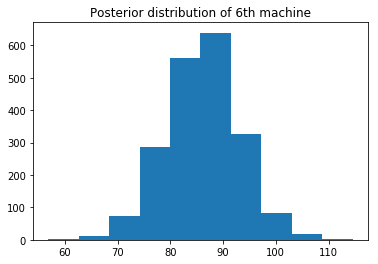

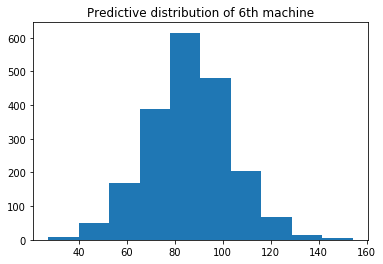

In [12]:
plot_i_ii()

##### Answer for iii)
This histogram for the 7th machine should be the same as in i) for the 6th machine because they have the same distribution also this case

### Hierarchical model
The answers are  after the source code.


In [13]:
%%capture
model="""
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
}
parameters {
    real mu0;             // prior mean
    real<lower=0> sigma0; // prior std
    vector[K] mu;         // group means
    real<lower=0> sigma;  // common std
}
model {
  mu0 ~ normal(10,10);      // weakly informative prior
  sigma0 ~ cauchy(0,4);     // weakly informative prior
  mu ~ normal(mu0, sigma0); // population prior with unknown parameters
  sigma ~ cauchy(0,4);      // weakly informative prior
  y ~ normal(mu[x], sigma);
}
generated quantities {
    real ypred_6; // predictive distribution for the 6th machine
    ypred_6 = normal_rng(mu[6], sigma);
}
"""

data = dict(N=30, K=6, x=x, y=y)
sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=data, iter=1000, chains=4)
samples = fit.extract(permuted=True)

def plot_i_ii():
    plt.hist(samples['mu'][:,5])
    plt.title('Posterior distribution of 6th machine')
    plt.show()
    plt.hist(samples['ypred_6'])
    plt.title('Predictive distribution of 6th machine')
    plt.show()
    

##### Stan model inference

In [15]:
print(fit)

Inference for Stan model: anon_model_21c2e5744abac4d4e83d90f1f235092a.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0      19.87     0.2  10.12  -0.36  13.16  20.23  26.65  39.86   2679    1.0
sigma0   76.63     0.6  27.34  40.53  58.57  71.16  88.57 141.83   2098    1.0
mu[1]    75.15    0.13   7.07  59.86  70.74  75.41  79.61  89.04   3092    1.0
mu[2]   105.29    0.12   6.57  92.25 101.09 105.41 109.63 118.33   2853    1.0
mu[3]    87.04    0.12   6.49  73.48  82.78  87.11  91.49  99.85   3048    1.0
mu[4]   110.87    0.12   6.67  97.42 106.29 110.84 115.39 124.02   3230    1.0
mu[5]    89.31    0.13   6.43  76.23  85.17  89.33  93.31 102.17   2450    1.0
mu[6]    85.47    0.12   6.88  71.58  81.03  85.43  89.98  99.28   3157    1.0
sigma    14.61    0.06   2.24  11.18  12.99  14.29   15.9  20.04   1488    1.0
ypred_6  85.32    0.36 

##### Answers for i) and ii)

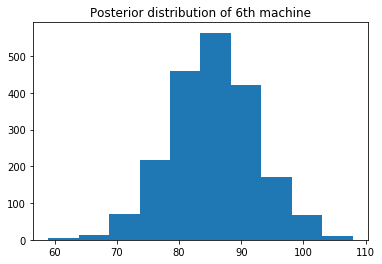

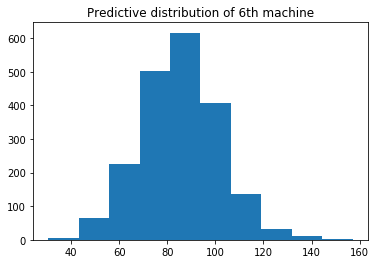

In [16]:
plot_i_ii()